<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/GRU_AE/GRU_AE_Gilt10y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 5.22 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Jul 20 12:30:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Gilt10y'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'GRU_AE'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 170 kB 70.9 MB/s 
     |████████████████████████████████| 133 kB 66.6 MB/s 
     |████████████████████████████████| 97 kB 7.1 MB/s 
     |████████████████████████████████| 138 kB 64.8 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 62 kB 801 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh', 'relu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

     # layer 1
    model.add(GRU(units=128, return_sequences=True, input_shape=(window_len, 1), activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 2
    model.add(GRU(units=64, return_sequences=False, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 3
    model.add(RepeatVector(window_len))
    # layer 4
    model.add(GRU(units=64, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 5
    model.add(GRU(units=128, return_sequences=False, activation=config.activation))
    model.add(Dropout(0.1))
    # layer 6
    model.add((Dense(1)))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: k2i3o8dl
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_GRU_AE/sweeps/k2i3o8dl


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: vritye3d with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/200
8/8 [==============================] - 31s 525ms/step - loss: 0.2352 - mean_squared_error: 0.2352 - mean_absolute_error: 0.4304 - val_loss: 0.1375 - val_mean_squared_error: 0.1375 - val_mean_absolute_error: 0.3077
Epoch 2/200
8/8 [==============================] - 2s 247ms/step - loss: 0.1102 - mean_squared_error: 0.1102 - mean_absolute_error: 0.2717 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.1322
Epoch 3/200
8/8 [==============================] - 2s 247ms/step - loss: 0.0181 - mean_squared_error: 0.0181 - mean_absolute_error: 0.1111 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1096
Epoch 4/200
8/8 [==============================] - 2s 250ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0778 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0880
Epoch 5/200
8/8 [==============================] - 2s 266ms/step - loss: 0.0048 - mean_squared_erro

epoch,15
loss,0.00297
mean_squared_error,0.00297
mean_absolute_error,0.04099
val_loss,0.01155
val_mean_squared_error,0.01155
val_mean_absolute_error,0.08304
_runtime,71
_timestamp,1626784360
_step,15
best_val_loss,0.01091


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
_timestamp,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██


wandb: Agent Starting Run: t7igluzw with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 13s 367ms/step - loss: 0.1335 - mean_squared_error: 0.1335 - mean_absolute_error: 0.2955 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1106
Epoch 2/100
16/16 [==============================] - 4s 259ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0866 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0907
Epoch 3/100
16/16 [==============================] - 4s 252ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0773 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0840
Epoch 4/100
16/16 [==============================] - 4s 258ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0614 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0984
Epoch 5/100
16/16 [==============================] - 4s 281ms/step - loss: 0.0062 - mean_sq

epoch,45
loss,0.00304
mean_squared_error,0.00304
mean_absolute_error,0.04204
val_loss,0.01164
val_mean_squared_error,0.01164
val_mean_absolute_error,0.0831
_runtime,206
_timestamp,1626784581
_step,45
best_val_loss,0.00908


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▃▃▆▄█▄▂▃▃▂▄▅▃▄▂▂▇▃█▁▁▁▂▁▁▂▁▁▁▁▁▄▅▅▅▁▃▂▂
val_mean_squared_error,▇▃▃▆▄█▄▂▃▃▂▄▅▃▄▂▂▇▃█▁▁▁▂▁▁▂▁▁▁▁▁▄▅▅▅▁▃▂▂
val_mean_absolute_error,█▄▃▅▄▇▄▂▃▃▃▃▅▃▄▂▂▆▃█▁▁▂▂▁▁▂▁▁▁▁▁▄▅▅▅▁▃▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rjp7j5fa with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 11s 110ms/step - loss: 0.0960 - mean_squared_error: 0.0960 - mean_absolute_error: 0.2357 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1101
Epoch 2/200
16/16 [==============================] - 0s 18ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0876 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0903
Epoch 3/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0501 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0796
Epoch 4/200
16/16 [==============================] - 0s 19ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0416 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0793
Epoch 5/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0028 - mean_square

epoch,114
loss,0.00109
mean_squared_error,0.00109
mean_absolute_error,0.02461
val_loss,0.00556
val_mean_squared_error,0.00556
val_mean_absolute_error,0.05777
_runtime,46
_timestamp,1626784664
_step,114
best_val_loss,0.00505


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▃▃▂▂▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▃▃▃▂▂▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ufesa0fc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 9s 246ms/step - loss: 0.1187 - mean_squared_error: 0.1187 - mean_absolute_error: 0.2616 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0963
Epoch 2/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0696 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1039
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0856 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0922
Epoch 4/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0582 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0851
Epoch 5/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0033 - mean_squared_error: 0.

epoch,99
loss,0.00155
mean_squared_error,0.00155
mean_absolute_error,0.03051
val_loss,0.00726
val_mean_squared_error,0.00726
val_mean_absolute_error,0.06413
_runtime,33
_timestamp,1626784724
_step,99
best_val_loss,0.00561


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▂▁▂▂▁▂▁▂▂▁▁▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▆▅▄▄▃▃▃▃▅▄▃▃▃▂▂▂▂▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_mean_squared_error,██▇▆▆▅▄▄▃▃▃▃▅▄▃▃▃▂▂▂▂▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_mean_absolute_error,█▇▇▆▆▅▄▄▄▃▃▃▅▄▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▂▁▂
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 2o4g95b4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 8s 149ms/step - loss: 1.0816 - mean_squared_error: 1.0816 - mean_absolute_error: 0.6740 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0979
Epoch 2/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0240 - mean_squared_error: 0.0240 - mean_absolute_error: 0.1242 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.1196
Epoch 3/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0330 - mean_squared_error: 0.0330 - mean_absolute_error: 0.1538 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1302
Epoch 4/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0344 - mean_squared_error: 0.0344 - mean_absolute_error: 0.1438 - val_loss: 0.0325 - val_mean_squared_error: 0.0325 - val_mean_absolute_error: 0.1488
Epoch 5/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0352 - mean_squared

epoch,39
loss,0.00403
mean_squared_error,0.00403
mean_absolute_error,0.04954
val_loss,0.00732
val_mean_squared_error,0.00732
val_mean_absolute_error,0.06641
_runtime,21
_timestamp,1626784753
_step,39
best_val_loss,0.00546


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▃▂▃▄▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▅▆█▆▇▇▂▆▇▃▇▃▆▂▁▂▂▃▄▂▂▁▁▂▃▄▃▄▁▁▂▃▁▂▂▃▂▁▁
val_mean_squared_error,▃▅▆█▆▇▇▂▆▇▃▇▃▆▂▁▂▂▃▄▂▂▁▁▂▃▄▃▄▁▁▂▃▁▂▂▃▂▁▁
val_mean_absolute_error,▄▆▇█▆▇▇▃▇█▄▇▃▇▃▁▃▂▄▅▂▃▁▁▂▄▅▄▅▁▂▃▄▂▂▂▄▂▁▂
_runtime,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda.default.svc.cluster.local/search\": context deadline exceeded","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda.default.svc.cluster.local/search": context deadline exceeded (<Response [500]>)
500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda.default.svc.cluster.local/search\": context deadline exceeded","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda.default.svc.cluster.local/search": context deadline exceeded (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: cytsazuh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 9s 243ms/step - loss: 1.2000 - mean_squared_error: 1.2000 - mean_absolute_error: 0.8951 - val_loss: 0.0577 - val_mean_squared_error: 0.0577 - val_mean_absolute_error: 0.2008
Epoch 2/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0520 - mean_squared_error: 0.0520 - mean_absolute_error: 0.1813 - val_loss: 0.0387 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1639
Epoch 3/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0342 - mean_squared_error: 0.0342 - mean_absolute_error: 0.1507 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1175
Epoch 4/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.1377 - val_loss: 0.0306 - val_mean_squared_error: 0.0306 - val_mean_absolute_error: 0.1477
Epoch 5/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0513 - mean_squared_error: 0.

epoch,16
loss,0.03425
mean_squared_error,0.03425
mean_absolute_error,0.14628
val_loss,0.04176
val_mean_squared_error,0.04176
val_mean_absolute_error,0.16262
_runtime,16
_timestamp,1626784856
_step,16
best_val_loss,0.0118


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▃▂▂▂▂▁▂▂▂
val_loss,▃▂▁▂▁▂▁▁█▂▂▂▁▂▁▂▂
val_mean_squared_error,▃▂▁▂▁▂▁▁█▂▂▂▁▂▁▂▂
val_mean_absolute_error,▄▃▂▃▁▂▁▁█▃▃▃▁▂▂▃▃
_runtime,▁▁▁▃▃▃▃▃▆▆▆▆▆▆▆██
_timestamp,▁▁▁▃▃▃▃▃▆▆▆▆▆▆▆██
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: tgkjk02k with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 10s 496ms/step - loss: 0.2094 - mean_squared_error: 0.2094 - mean_absolute_error: 0.3986 - val_loss: 0.0431 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1707
Epoch 2/200
8/8 [==============================] - 2s 261ms/step - loss: 0.0423 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1678 - val_loss: 0.0303 - val_mean_squared_error: 0.0303 - val_mean_absolute_error: 0.1455
Epoch 3/200
8/8 [==============================] - 2s 266ms/step - loss: 0.0304 - mean_squared_error: 0.0304 - mean_absolute_error: 0.1349 - val_loss: 0.0300 - val_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.1432
Epoch 4/200
8/8 [==============================] - 2s 256ms/step - loss: 0.0219 - mean_squared_error: 0.0219 - mean_absolute_error: 0.1159 - val_loss: 0.0196 - val_mean_squared_error: 0.0196 - val_mean_absolute_error: 0.1157
Epoch 5/200
8/8 [==============================] - 2s 272ms/step - loss: 0.0137 - mean_squared_erro

epoch,18
loss,0.00278
mean_squared_error,0.00278
mean_absolute_error,0.04005
val_loss,0.01383
val_mean_squared_error,0.01383
val_mean_absolute_error,0.09056
_runtime,55
_timestamp,1626784922
_step,18
best_val_loss,0.01135


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▃▂▂▁▁▁▁▁▁▁▁▂▂▂▂▂
val_mean_squared_error,█▅▅▃▂▂▁▁▁▁▁▁▁▁▂▂▂▂▂
val_mean_absolute_error,█▆▆▄▂▂▁▁▁▁▁▁▁▁▂▂▂▂▂
_runtime,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██


wandb: Agent Starting Run: 4dzir1pm with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 11s 513ms/step - loss: 0.3351 - mean_squared_error: 0.3351 - mean_absolute_error: 0.5008 - val_loss: 0.0893 - val_mean_squared_error: 0.0893 - val_mean_absolute_error: 0.2366
Epoch 2/200
8/8 [==============================] - 2s 286ms/step - loss: 0.0580 - mean_squared_error: 0.0580 - mean_absolute_error: 0.1848 - val_loss: 0.0322 - val_mean_squared_error: 0.0322 - val_mean_absolute_error: 0.1454
Epoch 3/200
8/8 [==============================] - 2s 270ms/step - loss: 0.0328 - mean_squared_error: 0.0328 - mean_absolute_error: 0.1421 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1233
Epoch 4/200
8/8 [==============================] - 2s 254ms/step - loss: 0.0276 - mean_squared_error: 0.0276 - mean_absolute_error: 0.1249 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1173
Epoch 5/200
8/8 [==============================] - 2s 260ms/step - loss: 0.0216 - mean_squared_erro

epoch,26
loss,0.00463
mean_squared_error,0.00463
mean_absolute_error,0.05352
val_loss,0.02089
val_mean_squared_error,0.02089
val_mean_absolute_error,0.11491
_runtime,72
_timestamp,1626785040
_step,26
best_val_loss,0.01007


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁
val_loss,█▃▂▂▂▁▃▄▂▁▁▂▂▂▁▂▁▁▁▂▁▂▂▁▁▁▂
val_mean_squared_error,█▃▂▂▂▁▃▄▂▁▁▂▂▂▁▂▁▁▁▂▁▂▂▁▁▁▂
val_mean_absolute_error,█▄▃▃▃▂▄▅▃▂▂▃▃▃▂▂▁▂▁▃▁▂▂▁▂▁▃
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: ot9g0yrc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 9s 241ms/step - loss: 0.1494 - mean_squared_error: 0.1494 - mean_absolute_error: 0.3018 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1094
Epoch 2/200
8/8 [==============================] - 0s 20ms/step - loss: 0.0199 - mean_squared_error: 0.0199 - mean_absolute_error: 0.1119 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0818
Epoch 3/200
8/8 [==============================] - 0s 22ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0546 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1148
Epoch 4/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0140 - mean_squared_error: 0.0140 - mean_absolute_error: 0.0986 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1095
Epoch 5/200
8/8 [==============================] - 0s 22ms/step - loss: 0.0085 - mean_squared_error: 0.

epoch,57
loss,0.00234
mean_squared_error,0.00234
mean_absolute_error,0.03774
val_loss,0.00703
val_mean_squared_error,0.00703
val_mean_absolute_error,0.06506
_runtime,25
_timestamp,1626785073
_step,57
best_val_loss,0.00517


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▃▂▂▂▂▂▂▂▁▁▂▂▃▁▁▁▁▂▂▁▁▂▁▂▂▁▁▁▂▂▁▁▁▂▁▁▁
val_loss,▆▃█▄▄▇▄▄▂▃▂▂▂▃▄▂▂▁▁▁▃▂▁▂▂▁▂▁▁▁▁▂▁▁▁▂▂▁▂▂
val_mean_squared_error,▆▃█▄▄▇▄▄▂▃▂▂▂▃▄▂▂▁▁▁▃▂▁▂▂▁▂▁▁▁▁▂▁▁▁▂▂▁▂▂
val_mean_absolute_error,▇▄█▅▅▇▄▄▃▄▂▂▂▄▅▃▂▂▁▁▃▂▁▂▂▁▂▁▂▁▁▂▁▁▁▂▂▁▂▂
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 1yn7rj34 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 8s 149ms/step - loss: 0.0556 - mean_squared_error: 0.0556 - mean_absolute_error: 0.1739 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0947
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0756 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0841
Epoch 3/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0660 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1081
Epoch 4/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0704 - val_loss: 0.0303 - val_mean_squared_error: 0.0303 - val_mean_absolute_error: 0.1427
Epoch 5/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0126 - mean_squared_erro

epoch,49
loss,0.0024
mean_squared_error,0.0024
mean_absolute_error,0.03711
val_loss,0.00586
val_mean_squared_error,0.00586
val_mean_absolute_error,0.05912
_runtime,26
_timestamp,1626785115
_step,49
best_val_loss,0.00586


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▃▂▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▃▂▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▄▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,▃▃▅█▄▃▂▃▂▂▂▂▂▂▂▃▂▂▂▃▂▁▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▂▁
val_mean_squared_error,▃▃▅█▄▃▂▃▂▂▂▂▂▂▂▃▂▂▂▃▂▁▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▂▁
val_mean_absolute_error,▄▃▅█▅▃▂▃▂▂▂▃▂▃▂▃▂▂▂▃▂▂▂▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: jhnubgse with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 11s 546ms/step - loss: 0.2296 - mean_squared_error: 0.2296 - mean_absolute_error: 0.4261 - val_loss: 0.1425 - val_mean_squared_error: 0.1425 - val_mean_absolute_error: 0.3160
Epoch 2/50
8/8 [==============================] - 2s 310ms/step - loss: 0.1353 - mean_squared_error: 0.1353 - mean_absolute_error: 0.3116 - val_loss: 0.0344 - val_mean_squared_error: 0.0344 - val_mean_absolute_error: 0.1522
Epoch 3/50
8/8 [==============================] - 2s 285ms/step - loss: 0.0282 - mean_squared_error: 0.0282 - mean_absolute_error: 0.1348 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - val_mean_absolute_error: 0.1692
Epoch 4/50
8/8 [==============================] - 2s 275ms/step - loss: 0.0239 - mean_squared_error: 0.0239 - mean_absolute_error: 0.1312 - val_loss: 0.0249 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.1309
Epoch 5/50
8/8 [==============================] - 2s 266ms/step - loss: 0.0215 - mean_squared_error: 0.

epoch,49
loss,0.00155
mean_squared_error,0.00155
mean_absolute_error,0.03062
val_loss,0.00918
val_mean_squared_error,0.00918
val_mean_absolute_error,0.07311
_runtime,125
_timestamp,1626785248
_step,49
best_val_loss,0.0085


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: le7jicts with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 9s 247ms/step - loss: 0.1295 - mean_squared_error: 0.1295 - mean_absolute_error: 0.2885 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.1041
Epoch 2/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0845 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.1116
Epoch 3/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0207 - mean_squared_error: 0.0207 - mean_absolute_error: 0.1122 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0851
Epoch 4/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0887 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1045
Epoch 5/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0136 - mean_squared_error: 0.

epoch,66
loss,0.00202
mean_squared_error,0.00202
mean_absolute_error,0.03331
val_loss,0.00719
val_mean_squared_error,0.00719
val_mean_absolute_error,0.06453
_runtime,24
_timestamp,1626785281
_step,66
best_val_loss,0.00567


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▂▁▂▂▁▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,▅▇▆▄▆█▄▅▃▂▂▃▂▂▃▂▃▂▂▃▂▂▄▂▂▁▁▄▃▁▁▂▁▁▂▂▂▁▂▂
val_mean_squared_error,▅▇▆▄▆█▄▅▃▂▂▃▂▂▃▂▃▂▂▃▂▂▄▂▂▁▁▄▃▁▁▂▁▁▂▂▂▁▂▂
val_mean_absolute_error,▆▇▆▄▆█▄▆▃▂▃▄▃▃▃▂▃▂▂▃▃▂▄▂▂▁▁▄▄▁▁▃▂▁▃▃▂▁▂▂
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ujy61s72 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 12s 559ms/step - loss: 0.1660 - mean_squared_error: 0.1660 - mean_absolute_error: 0.3390 - val_loss: 0.0622 - val_mean_squared_error: 0.0622 - val_mean_absolute_error: 0.2009
Epoch 2/100
8/8 [==============================] - 2s 281ms/step - loss: 0.0690 - mean_squared_error: 0.0690 - mean_absolute_error: 0.2008 - val_loss: 0.0385 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1642
Epoch 3/100
8/8 [==============================] - 2s 299ms/step - loss: 0.0318 - mean_squared_error: 0.0318 - mean_absolute_error: 0.1515 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1336
Epoch 4/100
8/8 [==============================] - 2s 291ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0856 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.1045
Epoch 5/100
8/8 [==============================] - 2s 294ms/step - loss: 0.0065 - mean_squared_erro

epoch,77
loss,0.00112
mean_squared_error,0.00112
mean_absolute_error,0.02565
val_loss,0.00575
val_mean_squared_error,0.00575
val_mean_absolute_error,0.059
_runtime,187
_timestamp,1626785478
_step,77
best_val_loss,0.00575


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: zfye8ats with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 19s 349ms/step - loss: 0.0820 - mean_squared_error: 0.0820 - mean_absolute_error: 0.2163 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0895
Epoch 2/200
32/32 [==============================] - 9s 272ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0704 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0915
Epoch 3/200
32/32 [==============================] - 8s 260ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0651 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0834
Epoch 4/200
32/32 [==============================] - 9s 267ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0531 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0911
Epoch 5/200
32/32 [==============================] - 8s 259ms/step - loss: 0.0056 - mean_sq

epoch,25
loss,0.00289
mean_squared_error,0.00289
mean_absolute_error,0.04151
val_loss,0.01298
val_mean_squared_error,0.01298
val_mean_absolute_error,0.08737
_runtime,239
_timestamp,1626785726
_step,25
best_val_loss,0.01031


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▅▂▄▂▂█▄▇▃▃▁▄▁▁▁▄▃▃▅▄▃▂▂▃▃
val_mean_squared_error,▃▅▂▄▂▂█▄▇▃▃▁▄▁▁▁▄▃▃▅▄▃▂▂▃▃
val_mean_absolute_error,▄▄▂▄▂▂█▄▇▃▂▁▄▁▁▁▃▃▃▅▅▃▂▁▄▃
_runtime,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: ldlezuo4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 14s 371ms/step - loss: 0.1094 - mean_squared_error: 0.1094 - mean_absolute_error: 0.2537 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1162
Epoch 2/50
16/16 [==============================] - 5s 282ms/step - loss: 0.0473 - mean_squared_error: 0.0473 - mean_absolute_error: 0.1669 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1125
Epoch 3/50
16/16 [==============================] - 4s 267ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0797 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0878
Epoch 4/50
16/16 [==============================] - 5s 291ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0787 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0762
Epoch 5/50
16/16 [==============================] - 5s 289ms/step - loss: 0.0042 - mean_squared

epoch,49
loss,0.0014
mean_squared_error,0.0014
mean_absolute_error,0.02916
val_loss,0.00669
val_mean_squared_error,0.00669
val_mean_absolute_error,0.06263
_runtime,233
_timestamp,1626786004
_step,49
best_val_loss,0.00612


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▃▃▃▂▂▂▂▂▁▁▁▂▁▂▂▂▁▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▂▂▂▂▄▃▂▂▂▂▃▂▂▃▂▂▁▁▁▂▁▂▂▁▂▁▁▂▁▁▁▁▃▁▁▂▁
val_mean_squared_error,█▇▄▂▂▂▂▄▃▂▂▂▂▃▂▂▃▂▂▁▁▁▂▁▂▂▁▂▁▁▂▁▁▁▁▃▁▁▂▁
val_mean_absolute_error,██▄▃▃▂▃▄▃▃▃▂▃▃▂▂▄▂▂▂▁▂▂▂▃▂▂▂▁▁▂▁▁▁▂▅▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 0sqbr5zo with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 13s 370ms/step - loss: 0.2125 - mean_squared_error: 0.2125 - mean_absolute_error: 0.4020 - val_loss: 0.0321 - val_mean_squared_error: 0.0321 - val_mean_absolute_error: 0.1482
Epoch 2/200
16/16 [==============================] - 4s 270ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - mean_absolute_error: 0.1406 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1332
Epoch 3/200
16/16 [==============================] - 4s 254ms/step - loss: 0.0173 - mean_squared_error: 0.0173 - mean_absolute_error: 0.1026 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0989
Epoch 4/200
16/16 [==============================] - 4s 258ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0640 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0806
Epoch 5/200
16/16 [==============================] - 4s 274ms/step - loss: 0.0044 - mean_sq

epoch,67
loss,0.00139
mean_squared_error,0.00139
mean_absolute_error,0.02854
val_loss,0.0076
val_mean_squared_error,0.0076
val_mean_absolute_error,0.06636
_runtime,311
_timestamp,1626786366
_step,67
best_val_loss,0.00737


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: mn550wdv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 10s 80ms/step - loss: 0.0640 - mean_squared_error: 0.0640 - mean_absolute_error: 0.1711 - val_loss: 0.0236 - val_mean_squared_error: 0.0236 - val_mean_absolute_error: 0.1213
Epoch 2/100
32/32 [==============================] - 1s 17ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0594 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0878
Epoch 3/100
32/32 [==============================] - 1s 18ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0483 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0887
Epoch 4/100
32/32 [==============================] - 1s 18ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0485 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0801
Epoch 5/100
32/32 [==============================] - 1s 17ms/step - loss: 0.0040 - mean_squared

epoch,66
loss,0.00084
mean_squared_error,0.00084
mean_absolute_error,0.02257
val_loss,0.0063
val_mean_squared_error,0.0063
val_mean_absolute_error,0.06062
_runtime,55
_timestamp,1626786451
_step,66
best_val_loss,0.00502


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▃▂▂▂▂▂▁▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▂▂▄▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▂▂▂▂▂▄▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▃▃▂▂▂▅▂▂▂▂▂▁▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: q2ghemcq with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 11s 504ms/step - loss: 0.2262 - mean_squared_error: 0.2262 - mean_absolute_error: 0.4214 - val_loss: 0.1210 - val_mean_squared_error: 0.1210 - val_mean_absolute_error: 0.2859
Epoch 2/50
8/8 [==============================] - 2s 272ms/step - loss: 0.0959 - mean_squared_error: 0.0959 - mean_absolute_error: 0.2526 - val_loss: 0.0276 - val_mean_squared_error: 0.0276 - val_mean_absolute_error: 0.1379
Epoch 3/50
8/8 [==============================] - 2s 255ms/step - loss: 0.0344 - mean_squared_error: 0.0344 - mean_absolute_error: 0.1593 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1300
Epoch 4/50
8/8 [==============================] - 2s 268ms/step - loss: 0.0207 - mean_squared_error: 0.0207 - mean_absolute_error: 0.1161 - val_loss: 0.0282 - val_mean_squared_error: 0.0282 - val_mean_absolute_error: 0.1368
Epoch 5/50
8/8 [==============================] - 2s 263ms/step - loss: 0.0202 - mean_squared_error: 0.

epoch,18
loss,0.00408
mean_squared_error,0.00408
mean_absolute_error,0.04752
val_loss,0.01341
val_mean_squared_error,0.01341
val_mean_absolute_error,0.08798
_runtime,55
_timestamp,1626786516
_step,18
best_val_loss,0.01075


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▂▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██


wandb: Agent Starting Run: 37ythd26 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 13s 509ms/step - loss: 0.2013 - mean_squared_error: 0.2013 - mean_absolute_error: 0.3896 - val_loss: 0.0340 - val_mean_squared_error: 0.0340 - val_mean_absolute_error: 0.1535
Epoch 2/50
8/8 [==============================] - 2s 274ms/step - loss: 0.0217 - mean_squared_error: 0.0217 - mean_absolute_error: 0.1235 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.1054
Epoch 3/50
8/8 [==============================] - 2s 274ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0791 - val_loss: 0.0144 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.0921
Epoch 4/50
8/8 [==============================] - 2s 275ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0721 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0858
Epoch 5/50
8/8 [==============================] - 2s 264ms/step - loss: 0.0041 - mean_squared_error: 0.

epoch,49
loss,0.00176
mean_squared_error,0.00176
mean_absolute_error,0.03212
val_loss,0.00831
val_mean_squared_error,0.00831
val_mean_absolute_error,0.07149
_runtime,128
_timestamp,1626786655
_step,49
best_val_loss,0.00831


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▂▁▂▁▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▄▃▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▂▂▄▃▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▂▂▂▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vlj8901u with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 8s 61ms/step - loss: 0.9600 - mean_squared_error: 0.9600 - mean_absolute_error: 0.5228 - val_loss: 0.1801 - val_mean_squared_error: 0.1801 - val_mean_absolute_error: 0.3983
Epoch 2/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0687 - mean_squared_error: 0.0687 - mean_absolute_error: 0.2060 - val_loss: 0.0442 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1758
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0385 - mean_squared_error: 0.0385 - mean_absolute_error: 0.1519 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0835
Epoch 4/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0271 - mean_squared_error: 0.0271 - mean_absolute_error: 0.1265 - val_loss: 0.0298 - val_mean_squared_error: 0.0298 - val_mean_absolute_error: 0.1455
Epoch 5/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0354 - mean_squared_

epoch,21
loss,0.00534
mean_squared_error,0.00534
mean_absolute_error,0.05675
val_loss,0.00856
val_mean_squared_error,0.00856
val_mean_absolute_error,0.07129
_runtime,23
_timestamp,1626786736
_step,21
best_val_loss,0.00568


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_loss,█▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,█▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,█▃▂▃▁▁▁▁▁▁▂▁▂▂▁▁▂▁▃▁▁▁
_runtime,▁▁▂▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: uf2sdax7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 9s 248ms/step - loss: 0.1007 - mean_squared_error: 0.1007 - mean_absolute_error: 0.2309 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0935
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0700 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1068
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0692 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0837
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0559 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0891
Epoch 5/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0042 - mean_squared_error: 0.

epoch,85
loss,0.00209
mean_squared_error,0.00209
mean_absolute_error,0.03494
val_loss,0.00645
val_mean_squared_error,0.00645
val_mean_absolute_error,0.06334
_runtime,29
_timestamp,1626786775
_step,85
best_val_loss,0.00583


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▂▂▁▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▂▂▁▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▃▃▂▃▃▃▃▃▃▃▂▂▁▁▁▂▂▁▁▂▂▁▂▁▁▂▂▂▂▁▁▂▂▁▁
val_loss,▅▄█▅▅▇▄▃▅▄▆▃▃▃▃▃▃▃▄▃▂▂▂▃▃▁▁▂▂▁▂▂▁▁▁▂▁▁▂▁
val_mean_squared_error,▅▄█▅▅▇▄▃▅▄▆▃▃▃▃▃▃▃▄▃▂▂▂▃▃▁▁▂▂▁▂▂▁▁▁▂▁▁▂▁
val_mean_absolute_error,▆▅█▅▅▇▄▃▆▄▇▄▄▃▄▄▃▃▄▃▃▂▂▄▄▂▂▂▂▁▂▂▂▂▁▂▁▁▂▁
_runtime,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: idzir7sp with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 14s 385ms/step - loss: 0.1098 - mean_squared_error: 0.1098 - mean_absolute_error: 0.2661 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1056
Epoch 2/200
16/16 [==============================] - 4s 271ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0667 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0977
Epoch 3/200
16/16 [==============================] - 5s 286ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0775 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.1540
Epoch 4/200
16/16 [==============================] - 5s 327ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0859 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0725
Epoch 5/200
16/16 [==============================] - 5s 287ms/step - loss: 0.0043 - mean_sq

epoch,75
loss,0.00094
mean_squared_error,0.00094
mean_absolute_error,0.02302
val_loss,0.00526
val_mean_squared_error,0.00526
val_mean_absolute_error,0.05573
_runtime,351
_timestamp,1626787138
_step,75
best_val_loss,0.00511


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▃▂▂▂▁▂▂▂▂▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_loss,█▇▃█▄▃▃▂▂▂▂▃▄▂▂▁▃▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,█▇▃█▄▃▃▂▂▂▂▃▄▂▂▁▃▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,█▇▃▇▅▃▃▂▂▂▂▃▄▂▂▁▄▂▂▂▁▂▂▁▁▁▁▁▁▁▂▂▁▁▁▁▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 8xsnojqp with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 13s 369ms/step - loss: 0.1728 - mean_squared_error: 0.1728 - mean_absolute_error: 0.3463 - val_loss: 0.0366 - val_mean_squared_error: 0.0366 - val_mean_absolute_error: 0.1606
Epoch 2/200
16/16 [==============================] - 4s 275ms/step - loss: 0.0362 - mean_squared_error: 0.0362 - mean_absolute_error: 0.1480 - val_loss: 0.0609 - val_mean_squared_error: 0.0609 - val_mean_absolute_error: 0.2219
Epoch 3/200
16/16 [==============================] - 4s 269ms/step - loss: 0.0296 - mean_squared_error: 0.0296 - mean_absolute_error: 0.1372 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1063
Epoch 4/200
16/16 [==============================] - 4s 281ms/step - loss: 0.0205 - mean_squared_error: 0.0205 - mean_absolute_error: 0.1143 - val_loss: 0.0234 - val_mean_squared_error: 0.0234 - val_mean_absolute_error: 0.1196
Epoch 5/200
16/16 [==============================] - 5s 285ms/step - loss: 0.0205 - mean_sq

epoch,46
loss,0.00238
mean_squared_error,0.00238
mean_absolute_error,0.03762
val_loss,0.00944
val_mean_squared_error,0.00944
val_mean_absolute_error,0.07693
_runtime,220
_timestamp,1626787369
_step,46
best_val_loss,0.00645


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▂▃▂▃▆▃▁▂▂▂▂▂▁▁▁▁▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁
val_mean_squared_error,▅█▂▃▂▃▆▃▁▂▂▂▂▂▁▁▁▁▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁
val_mean_absolute_error,▅█▃▄▃▃▆▃▂▂▂▃▃▂▁▂▁▁▁▂▂▂▁▃▁▁▁▁▁▂▁▁▂▃▁▁▁▁▂▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ehjcmrx7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 18s 320ms/step - loss: 0.0838 - mean_squared_error: 0.0838 - mean_absolute_error: 0.2088 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1041
Epoch 2/100
32/32 [==============================] - 9s 286ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0722 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1202
Epoch 3/100
32/32 [==============================] - 9s 283ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0875 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0880
Epoch 4/100
32/32 [==============================] - 9s 290ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0634 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0932
Epoch 5/100
32/32 [==============================] - 9s 273ms/step - loss: 0.0069 - mean_sq

epoch,43
loss,0.00142
mean_squared_error,0.00142
mean_absolute_error,0.02921
val_loss,0.00678
val_mean_squared_error,0.00678
val_mean_absolute_error,0.06496
_runtime,402
_timestamp,1626787782
_step,43
best_val_loss,0.0063


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▂▂▂▂▂▂▂▂▁▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,▆█▃▅▂▂▃▄▂▂▂▂▃▂▂▂▂▁▂▁▁▂▂▁▁▁▁▁▁▂▁▁▂▁▁▁▂▁▁▁
val_mean_squared_error,▆█▃▅▂▂▃▄▂▂▂▂▃▂▂▂▂▁▂▁▁▂▂▁▁▁▁▁▁▂▁▁▂▁▁▁▂▁▁▁
val_mean_absolute_error,▆█▄▅▃▂▃▄▃▃▂▂▃▂▃▂▂▁▂▂▂▂▂▁▁▁▁▁▁▂▁▁▂▁▂▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: r2pheguk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 8s 231ms/step - loss: 0.1292 - mean_squared_error: 0.1292 - mean_absolute_error: 0.2865 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0995
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - mean_absolute_error: 0.0985 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0750
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0626 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0736
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0529 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0660
Epoch 5/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0031 - mean_squared_error: 0.0031 

epoch,49
loss,0.00113
mean_squared_error,0.00113
mean_absolute_error,0.02594
val_loss,0.00538
val_mean_squared_error,0.00538
val_mean_absolute_error,0.05573
_runtime,23
_timestamp,1626787816
_step,49
best_val_loss,0.00528


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: uj0dipbo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 9s 328ms/step - loss: 0.1435 - mean_squared_error: 0.1435 - mean_absolute_error: 0.3069 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1077
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0864 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0937
Epoch 3/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0820 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0844
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0882 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0817
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0063 - mean_squared_error: 0.

epoch,20
loss,0.00589
mean_squared_error,0.00589
mean_absolute_error,0.05927
val_loss,0.01045
val_mean_squared_error,0.01045
val_mean_absolute_error,0.07736
_runtime,18
_timestamp,1626787855
_step,20
best_val_loss,0.00936


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▃▂▃▂▃▂▂▂▂▂▁▂▁▂▂▁▁▁
val_loss,▃▂▁▁█▄▃▃▁▄▁▂▁▄▂▂▂▃▂▁▁
val_mean_squared_error,▃▂▁▁█▄▃▃▁▄▁▂▁▄▂▂▂▃▂▁▁
val_mean_absolute_error,▄▂▂▂█▄▄▄▁▅▁▃▁▄▂▃▃▄▂▁▁
_runtime,▁▁▁▁▃▃▃▃▃▆▆▆▆▆▆██████
_timestamp,▁▁▁▁▃▃▃▃▃▆▆▆▆▆▆██████
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 7rmc0viv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 9s 66ms/step - loss: 0.0523 - mean_squared_error: 0.0523 - mean_absolute_error: 0.1595 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0895
Epoch 2/200
32/32 [==============================] - 0s 15ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0554 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1297
Epoch 3/200
32/32 [==============================] - 0s 15ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0629 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0824
Epoch 4/200
32/32 [==============================] - 0s 15ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0604 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0805
Epoch 5/200
32/32 [==============================] - 0s 15ms/step - loss: 0.0040 - mean_squared_

epoch,47
loss,0.00163
mean_squared_error,0.00163
mean_absolute_error,0.03033
val_loss,0.00586
val_mean_squared_error,0.00586
val_mean_absolute_error,0.06125
_runtime,39
_timestamp,1626787907
_step,47
best_val_loss,0.00524


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄█▃▃▃▃▃▂▂▂▂▂▃▂▃▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄█▃▃▃▃▃▂▂▂▂▂▃▂▃▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄█▄▃▄▄▃▃▃▂▂▂▃▂▄▂▂▂▂▁▁▂▂▁▂▁▁▂▁▂▁▁▂▂▂▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: x1z8a8eh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 8s 62ms/step - loss: 0.0822 - mean_squared_error: 0.0822 - mean_absolute_error: 0.2016 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0825
Epoch 2/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0621 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0808
Epoch 3/50
32/32 [==============================] - 1s 18ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0514 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0799
Epoch 4/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0528 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0809
Epoch 5/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0051 - mean_squared_error

epoch,49
loss,0.00157
mean_squared_error,0.00157
mean_absolute_error,0.03002
val_loss,0.00729
val_mean_squared_error,0.00729
val_mean_absolute_error,0.06497
_runtime,47
_timestamp,1626787966
_step,49
best_val_loss,0.00608


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▆▆▆▆▅▅▅▄▄▅█▄▄▃▃▃▃▃▃▃▃▂▄▂▃▂▂▂▂▂▂▁▂▁▁▂▁▁▂
val_mean_squared_error,▇▆▆▆▆▅▅▅▄▄▅█▄▄▃▃▃▃▃▃▃▃▂▄▂▃▂▂▂▂▂▂▁▂▁▁▂▁▁▂
val_mean_absolute_error,▇▇▆▇▇▆▆▆▅▅▅█▄▅▄▄▄▃▃▃▄▃▃▅▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: n034fk7a with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 17s 335ms/step - loss: 0.0913 - mean_squared_error: 0.0913 - mean_absolute_error: 0.2228 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0887
Epoch 2/100
32/32 [==============================] - 9s 288ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0666 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.1141
Epoch 3/100
32/32 [==============================] - 9s 295ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0645 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0908
Epoch 4/100
32/32 [==============================] - 8s 261ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0566 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0824
Epoch 5/100
32/32 [==============================] - 9s 268ms/step - loss: 0.0045 - mean_sq

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 200,
    'batch_size': 64,
    'learning_rate': 0.005,
    'dropout': 0.1,
    'optimizer': 'nadam',
    'activation': 'relu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(GRU(units=128, return_sequences=True, input_shape=(window_len, 1), activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 2
model.add(GRU(units=64, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 3
model.add(RepeatVector(window_len))
# layer 4
model.add(GRU(units=64, return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 5
model.add(GRU(units=128, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(0.1))
# layer 6
model.add((Dense(1)))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  187137


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 128)           50304     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 30, 64)            24960     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 64)            0

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/200
20/20 [==============================] - 12s 224ms/step - loss: 0.0844
Epoch 2/200
20/20 [==============================] - 4s 225ms/step - loss: 0.0141
Epoch 3/200
20/20 [==============================] - 5s 225ms/step - loss: 0.0104
Epoch 4/200
20/20 [==============================] - 5s 225ms/step - loss: 0.0072
Epoch 5/200
20/20 [==============================] - 5s 228ms/step - loss: 0.0052
Epoch 6/200
20/20 [==============================] - 4s 218ms/step - loss: 0.0044
Epoch 7/200
20/20 [==============================] - 4s 219ms/step - loss: 0.0055
Epoch 8/200
20/20 [==============================] - 4s 208ms/step - loss: 0.0043
Epoch 9/200
20/20 [==============================] - 4s 209ms/step - loss: 0.0048
Epoch 10/200
20/20 [==============================] - 4s 217ms/step - loss: 0.0019
Epoch 11/200
20/20 [==============================] - 4s 215ms/step - loss: 0.0055
Epoch 12/200
20/20 [==============================] - 4s 215ms/step - loss: 0.0031
Epoch 13/200

In [22]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

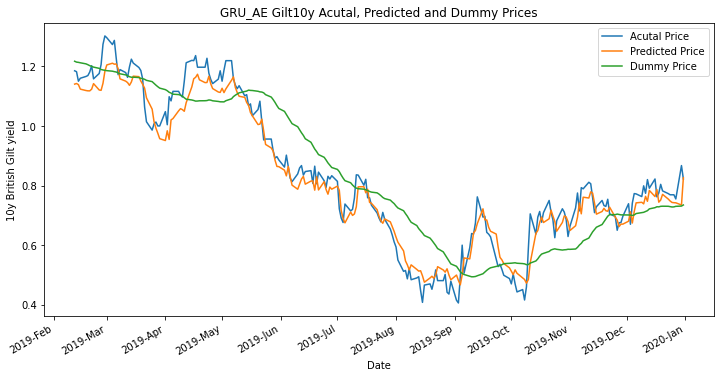

In [23]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

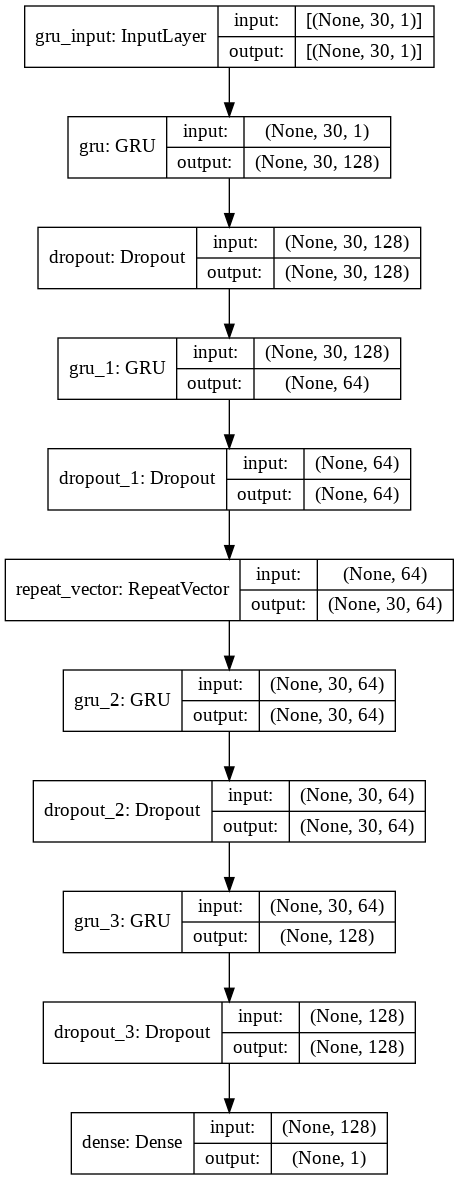

In [24]:
plot_model(model, show_shapes=True, expand_nested=True)

In [25]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0031630180168383416
RMSE:  0.05624071493889762
MAE:  0.04487700298677355
Dummy MSE:  0.013891737694778073
Dummy RMSE:  0.11786321603782103
Dummy MAE:  0.09977998323101281


In [26]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_AE_Gilt10y/assets
